Enter names of students working in a team of two here: [Tong Li] [Ning Liang]

# Exercise XCT #3 – Signal and Noise, Undersampling and Motion Artefacts

The objective of the exercise is to extend the CT simulator to take into consideration realistic experimental
parameters including Poisson noise. To assess image quality, the image signal-to-noise ratio (SNR) will be
determined and manipulated by changing experimental parameters and filter settings. The impact of radial
undersampling on image quality and the presence of object motion will be studied.

Some functionality that was implemented in the previous exercises was moved into the file `local_functions.py`.
Use these functionalities by importing the module `local_functions`. Whenever you see a function call or the use of pre-defined constants like `local_functions.calculate_discrete_phantom(...)` or `local_functions.tissue_densities` have a look into the file to understand what it is doing.
## Imports

In [2]:
from IPython.display import clear_output
from pint import Quantity
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt
import local_functions

%matplotlib inline

## Constants

In [3]:
# Define image matrix size
matrix = (256, 256)

# Define ticks and label for image display
xticks = np.unique(np.concatenate([np.linspace(0, matrix[0]//2, 4), np.linspace(matrix[0]//2, matrix[0], 4)]))
yticks = np.unique(np.concatenate([np.linspace(0, matrix[1]//2, 4), np.linspace(matrix[0]//2, matrix[1], 4)]))
xtick_labels = [f"{t:1.0f}" for t in xticks - matrix[0]//2]
ytick_labels = [f"{t:1.0f}" for t in yticks - matrix[1]//2]

##### Section 1 - Photon Flux

#### Task 1.1
> Given an X-ray tube with parameters given below, calculate the total number of electrons $N_e$ hitting the tungsten anode per unit time and the resulting number of X-ray photons per unit time $N_0$ sent to the object. Use the Quantity package to check for the right units. 
> - tube voltage: $50 kV$
> - anode current: $100 mA$
> - anode material: $Tungsten$
> - relative X-ray yield $\eta$ = $10^{-15}·Z kV^{-1}$ ($Z$: atomic number)
> - X-ray burst duration: $10 ms$ 

*Type your answer here*

$$ N_e = \frac{I_a}{e}$$ 

$$N_0 = \eta \; U_a N_e T_b = \eta \cdot \frac{U_a\cdot I_a\cdot T_b}{e}$$
$$N_0 = 1\times 10^{-15} \text{kV}^{-1} \frac{50 \text{kV} \cdot 100 \times 10^{-3} \text{A} \cdot 10 \times 10^{-3} \text{s}}
{1.6\times 10^{-19} \text{C} }$$


In [4]:
# TASK: Define parameters
Ua = 50000
Ia = 0.1
Tb = 0.01
e = 1.602*(10**(-19))
Z = 74
eta = 10**(-18)*Z

# TASK: Calculate electron and photon flux
Ne = Ia/e
N0 = eta * Ua * Ne * Tb

# Print electron and photon flux in scientific notation
print('Ne: ', format(Ne, ".2e"))
print('N0: ', format(N0, ".2e"))

Ne:  6.24e+17
N0:  2.31e+04


#### Task 1.2 
> Calculate the number of photons N that are transmitted through the object (use LaTeX style writing for presenting your results).


*Type your answer here*

$$N = N_0 \exp(-\mu x) $$



#### Task 1.3 
> Calculate the line integral using the given function `local_functions.calculate_line_integrals` then calculate the number of photons $N$ and by rearranging Beer-Lamberts law compute the modifed sinogram!

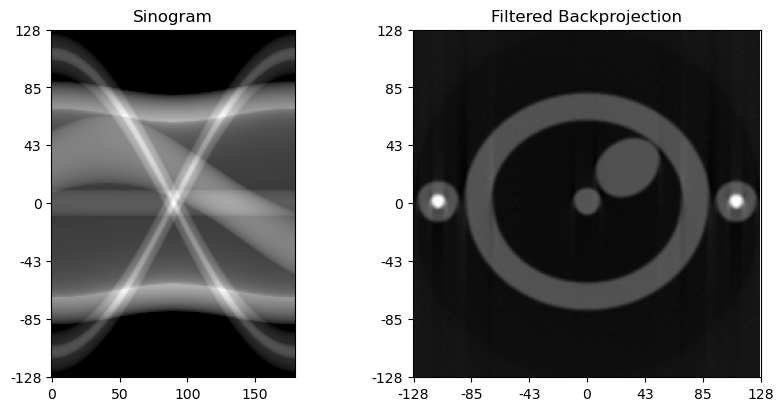

In [6]:
# Define phantom
phantom = local_functions.define_thorax_phantom("50keV")

# Define projection angles and detector bins
projection_angles = np.arange(0, 180)
detector_bins = 256

# TASK: Calculate sinograms
sinogram = local_functions.calculate_line_integrals(detector_bins, projection_angles, phantom)

# TASK: Calculate the number of photons N
N = N0*np.exp(-sinogram)
    
# TASK: Calculate modified sinogram
sinogram = np.log(N0/N)
    
# Calculate filtered backprojections from sinograms
image  = local_functions.filtered_back_projection(sinogram, matrix, projection_angles)

# Plot sinograms and filtered backprojection
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].imshow(sinogram.T, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("Sinogram")

axes[1].imshow(image.T, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("Filtered Backprojection"); 

#### Task 1.4  
> Add Poisson noise to the sinogram. Copy the code from Task 1.3 and refer to function `np.random.poisson()`!

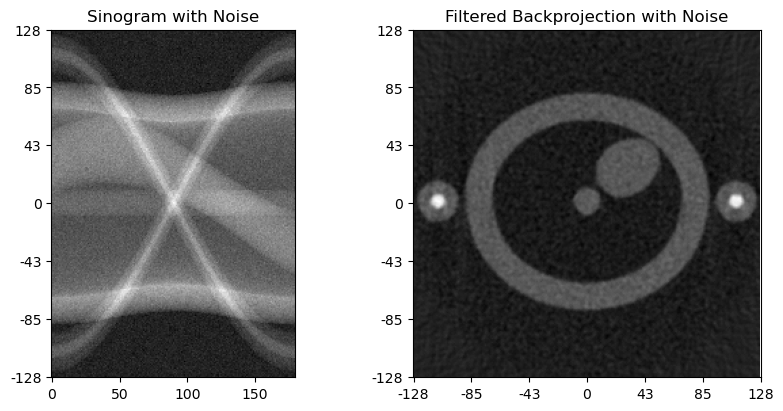

In [6]:
# TASK: Calculate sinograms
sinogram = local_functions.calculate_line_integrals(detector_bins, projection_angles, phantom)

# TASK: Calculate the number of photons N
N = N0*np.exp(-sinogram)
        
# TASK: Add Poisson noise
N = np.random.poisson(N)

# Set NaNs (Not a Number) and zeros to epsilon
N[np.where(np.logical_not(np.isfinite(N)))] = np.finfo(float).eps
N[np.where(N == 0)] = np.finfo(float).eps
 
# TASK: Fill sinogram
sinogram = np.log(N0/ N)
        
# Calculate filtered backprojections from sinograms
image  = local_functions.filtered_back_projection(sinogram, matrix, projection_angles)

# Plot sinograms and filtered backprojection
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].imshow(sinogram.T, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("Sinogram with Noise")

axes[1].imshow(image.T, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("Filtered Backprojection with Noise");

## Section 2 - Noise Filtering

### Task 2.1 
> Calculate a Gaussian filter in the Fourier domain and apply it to the noisy data produced in Task 1.4. How would you calculate standard deviation $\sigma$ to obtain a desired full-width-at-half-maximum (FWHM) in the spatial frequency domain as shown in the figure below?
$$filter = \exp \bigg \{\frac{-(p^2 + q^2)}{2 * \sigma^2}\bigg \}$$

![Figure 1](figure1.png)

*Type your answer here*
$$\sigma = \frac{FWHM}{\; 2 * \sqrt{2 * \log(2)}}$$

### Task 2.2 
> Modify function `calculate_gaussian_filter` to calculate the filter. Include a resolution reduction factor; set the `factor = [1,4,16]` and discuss how resolution and signal-to-noise ratio (SNR) relate to one another! 

In [7]:
def calculate_gaussian_filter(factor):
    
    # Matrix coordinates
    p,q = np.meshgrid(np.arange(- np.fix((matrix[0]) / 2),np.fix((matrix[0]) / 2)),
                      np.arange(- np.fix((matrix[1]) / 2),np.fix((matrix[1]) / 2)))
   
    # Full-width-at-half-maximum (fwhm)
    fwhm = matrix[0]
       
    # TASK: Calculate standard deviation sigma 
    sigma = fwhm/factor/2/np.sqrt(2*np.log(2))
    
    # TASK: Calculate filter
    filt = np.exp(-(p**2+q**2)/(2*sigma**2))
    
    return filt

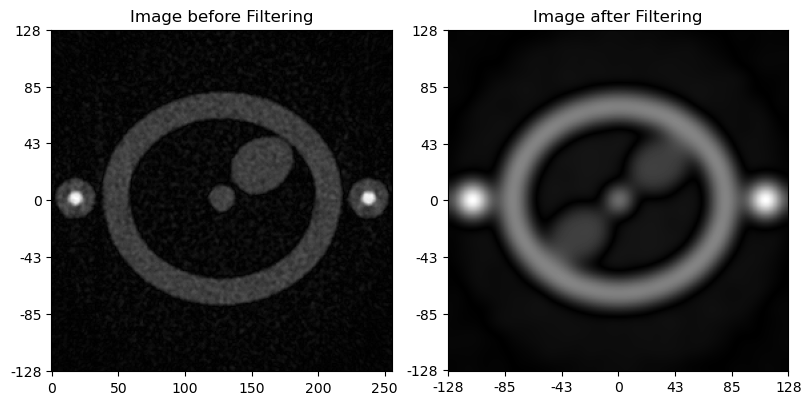

In [8]:
# Resolution reduction factor
factor = 16

# Calculate filter
filt = calculate_gaussian_filter(factor)
    
# TASK: Transform image into Fourier domain data
data = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image))).real

# TASK: Apply filter to the data
data = data*filt

# TASK: Transform filtered Fourier domain data into image
image_ = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(data)))

# Plot image before and after filtering
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].imshow(abs(image.T), origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("Image before Filtering")

axes[1].imshow(abs(image_.T), origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("Image after Filtering");

*Type your answer here*：SNR is inversely proportional to resolution.


### Task 2.3 
> Let’s measure the signal-to-noise ratio (SNR) in the static heart. Modify the function `calculate_snr` to compute the signal-to-noise ratio inside the heart region. Repeat the measurement for different resolution reduction factors and note down the results!

In [9]:
def calculate_snr(phantom, image):
    
    # Coordinates in matrix
    x,y = np.meshgrid(np.arange(-np.fix((matrix[0])/2),np.fix((matrix[0])/2)),
                      np.arange(-np.fix((matrix[1])/2),np.fix((matrix[1])/2)))
    
    # TASK: Set index corresponding to ellipse of "heart"
    heart_index = 7
    
    # Get theta
    theta = np.deg2rad(phantom[heart_index].theta)
   
    # Get coordinates
    X0 = np.array([[x.T - phantom[heart_index].x0],[y.T - phantom[heart_index].y0]]).reshape(2,256**2)

    # Fill diagonal matrix D (reduce ellipse size to avoid edge pixels)
    D = np.array([[1/(phantom[heart_index].a - 3), 0],[ 0, 1/(phantom[heart_index].b -3)]])
    
    # Fill rotation matrix Q 
    Q = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

    # Find points inside heart 
    equ = np.sum(np.dot(np.dot(D,Q), X0)**2, axis=0)
    index = np.where(equ <=1)[0]
    
    # TASK: Calculate signal
    signal = image.T.flatten()[index]
    
    # TASK: Calculate signal-to-noise ratio
    snr = abs(np.mean(signal)) / np.std(signal)
    
    return(snr)

In [10]:
# Calculate signal-to-noise ratio of heart
snr = calculate_snr(phantom, image_)

print('SNR: ', format(snr, ".3"))

SNR:  3.32


*Type your answer here*
> $$f=4,SNR=32.0$$
> $$f=1,SNR=18.1$$
> $$f=16,SNR=9.76$$

### Task 2.4
> Measure and plot SNR as a function of anode current $I_a$! 
> Which relation can be seen and why?

*Insert figure and type your answer here*
> $$signal \propto I_a$$
> $$SNR\propto\sqrt{I_a}$$
> ![Figure ](SNR-1(2).png)

### Task 2.5
> Measure and plot SNR as a function of burst duration $T_b$! 
> Which relation can be seen and why?

*Insert figure and type your answer here*
> $$signal \propto T_b$$
> $$SNR\propto T_b$$
> ![Figure ](SNR2.png)

## Section 3 - Motion Artefacts

### Task 3.1 
> Let the heart beat. Implement code to simulate sinusoidal contraction of the heart (at a burst duration of 40
ms the heart will perform a full cycle every 25 bursts = 1 heart beat/sec). Run the simulation and inspect sinogram and images. What is seen and why?
> Hint: To change the size of the heart over a cardiac cycle, model the heart size in a sinusoidal fashion e.g.

$$\text{phantom} = \text{heart\_axis} + \text{amplitude} * \sin \big(\text{frequency} \big) $$

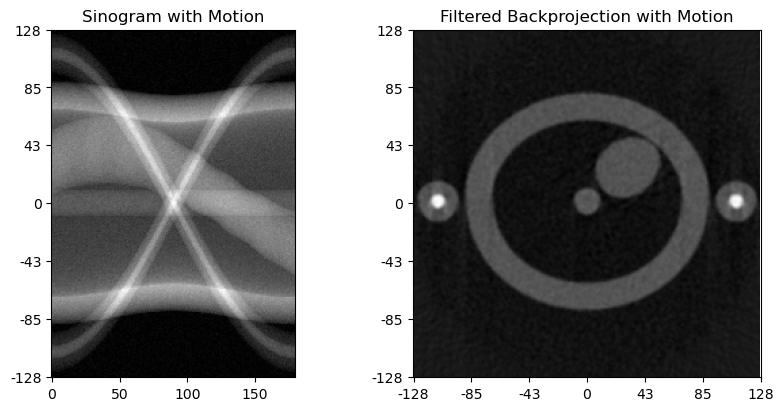

In [15]:
# TASK: Set burst duration
Tb = 0.04

# TASK: Calculate photon flux
N0 =  eta * Ua * Ne * Tb

# TASK: Set index corresponding to ellipse of "heart"
heart_index = 7

# TASK: Set heart short-axis size
heart_axis = phantom[heart_index].b

# Define projection angles
projection_angles = np.arange(0, 180)

# Define sinogram placeholder
sinogram = np.zeros((matrix[0],len(projection_angles)))

# Set plot
plt.figure()

# Loop over all projection angles
for i, phi in enumerate(projection_angles):
    
    # TASK: Change heart short axis
    phantom[heart_index].b = heart_axis + np.sin(2*np.pi*Tb*i)
    # Calculate phantom
    phantom_image = local_functions.calculate_discrete_phantom(matrix, phantom)
    
    # Calculate sinogram
    sinogram[:,i] = local_functions.calculate_line_integrals(detector_bins, phi, phantom)
    
    # TASK: Calculate photon flux
    N = N0*np.exp(-sinogram[:,i])
    
    # TASK: Add Poisson noise
    N = np.random.poisson(N)
    
    # Set NaNs (Not a Number) and zeros to epsilon
    N[np.where(np.logical_not(np.isfinite(N)))] = np.finfo(float).eps
    N[np.where(N == 0)] = np.finfo(float).eps

    # TASK: Fill sinogram
    sinogram[:,i] = np.log(N0/ N)
    
    # Display phantom
    plt.imshow(abs(phantom_image), origin="lower", cmap="gray")
    plt.show()

clear_output(wait=True)
  
# Calculate filtered backprojections from sinograms
image = local_functions.filtered_back_projection(sinogram.T, matrix, projection_angles)

# Plot phantom and sinogram
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].imshow(abs(sinogram), origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("Sinogram with Motion")

axes[1].imshow(image.T, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels)
axes[1].set_title("Filtered Backprojection with Motion");

### Task 3.2 
> To address the motion problem, you may radially undersample by an undersampling factor R i.e. projections are skipped and hence the overall imaging process is faster. Set undersampling factor R to 2, 4 and 8 and analyze the resulting images. Which undersampling factor R needs to be chosen to "freeze" the heart?

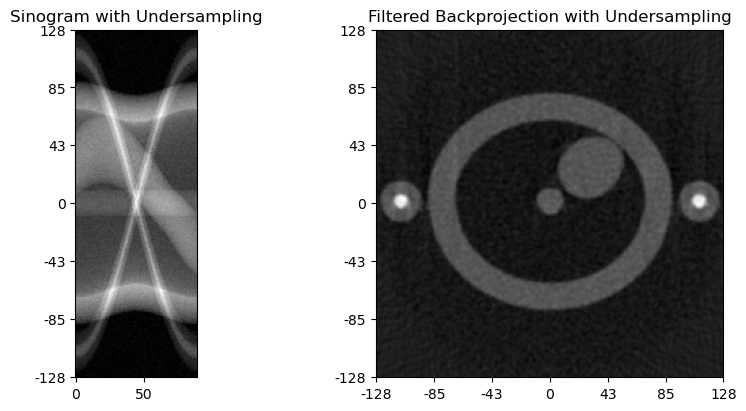

In [16]:
# TASK: Define undersampling factor
R = 2
projection_angles = np.linspace(0,179,int(np.round(180/R)))

# TASK: Set burst duration
Tb = 0.04

# TASK: Calculate photon flux
N0 =  eta * Ua * Ne * Tb

# TASK: Set index corresponding to ellipse of "heart"
heart_index = 7

# TASK: Set heart short-axis size
heart_axis = phantom[heart_index].b

# Define sinogram placeholder
sinogram = np.zeros((matrix[0],len(projection_angles)))

# Loop over all projection angles
for i, phi in enumerate(projection_angles):
    
    # TASK: Change heart short axis
    phantom[heart_index].b = heart_axis + np.sin(2*np.pi*Tb*i)
    
    # Calculate phantom
    phantom_image = local_functions.calculate_discrete_phantom(matrix, phantom)
    
    # Calculate sinogram
    sinogram[:,i] = local_functions.calculate_line_integrals(detector_bins, phi, phantom)
    
    # TASK: Calculate photon flux
    N = N0*np.exp(-sinogram[:,i])
    
    # TASK: Add Poisson noise
    N = np.random.poisson(N)
    
    # Set NaNs (Not a Number) and zeros to epsilon
    N[np.where(np.logical_not(np.isfinite(N)))] = np.finfo(float).eps
    N[np.where(N == 0)] = np.finfo(float).eps

    # TASK: Fill sinogram
    sinogram[:,i] = np.log(N0/ N)
      
# Calculate filtered backprojections from sinograms
image = local_functions.filtered_back_projection(sinogram.T, matrix, projection_angles)

# Plot phantom and sinogram
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].imshow(abs(sinogram), origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("Sinogram with Undersampling")

axes[1].imshow(image.T, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels)
axes[1].set_title("Filtered Backprojection with Undersampling");

### Task 3.3 
> Discuss the trade-off between imaging speed, motion artefacts and SNR! How can the motion problem
be dealt with in a clinical setting?

*Type in answer* ：If increasing imaging speed,the motion artefacts will decrease but the SNR will decrease as well.For clinical setting ,we can ask the patient to hold the breathe or take a belt.
